# Prototype 2 > Experiment 3

## --- Dependencies ---

In [1]:
# Standard Dependencies
import sys
import os
import numpy as np
from tabulate import tabulate
import torch
from time import time
import torch.nn as nn

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global Dependencies
from src.autoencoder import AutoEncoder, RMSELoss
from src.custom_types import Behavior, Execution, Evaluation, MTDTechnique, actions, mitigated_by
from src.data_provider import DataProvider
from src.functions import split_training_data, split_data, calculate_balance_metrics, run_sample_distribution_experiment
from src.sampling_probabilities import unit_sampling_probabilities, regular_sampling_probabilities, inverted_sampling_probabilities, \
    weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, \
    medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, \
    strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02

In [3]:
from src.environment import Environment
from src.deep_q_network import DeepQNetwork
from src.agent import Agent
from src.client import Client
from src.server import Server
from src.experiment import Experiment

In [4]:
rl_training_data, test_data, _ = DataProvider.get_scaled_train_test_split_one(scaling_minmax=True, scale_normal_only=True)
normal_data = rl_training_data[Behavior.NORMAL]
threshold = int(len(normal_data) * 0.5)

rl_training_data[Behavior.NORMAL] = normal_data[:threshold]

ae_training_data = normal_data[threshold:]  # use remaining samples for autoencoder
ae_training_x, ae_valid_x = split_data(ae_training_data)

N_FEATURES = normal_data.shape[1] -1
flattend_test_data = np.empty([0, N_FEATURES+1])
for behavior, behavior_data in test_data.items():
    if behavior == Behavior.NORMAL:
        NR_SAMPLES = 2800
        behavior_data[:, -1] =  0
    else:
        NR_SAMPLES = 400
        behavior_data[:, -1] = 1
    #y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * NR_SAMPLES)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:NR_SAMPLES]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
ae_test_y = flattend_test_data[:,-1].astype(int)

rl_training_data_strides = split_training_data(rl_training_data, 10)

In [5]:
autoencoder = AutoEncoder(ae_valid_x, ae_test_x, ae_test_y, rl_training_data, n_hidden_1=64, n_hidden_2=16, activation_function=nn.GELU())
autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=50, batch_size=64, verbose=False)

In [6]:
autoencoder.evaluate(n_std=5, tablefmt='latex_raw')

\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 98.85\%    & \notCalculated & \notCalculated & \notCalculated &        3985 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        5300 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2576 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        3842 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        4077 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2079 \\
 CNC\_OPT1                & 99.87\%    & \notCalculated & \notCalculated & \notCalculated &        3044 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2142 \\

---
## Experiment 2.3.1 (Weak Client Exclusive Class Setting)

In [7]:
p2e3v1 = run_sample_distribution_experiment(rl_training_data_strides, test_data, weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, autoencoder, 30, 100, False)



Dataset Balance Metrics: MID=0.0198 & WCS=0.9574
Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

Global Agent > Performance Evaluation after Round 0
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0.38 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      46.06 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      99.32 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |       0    | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |       0.4

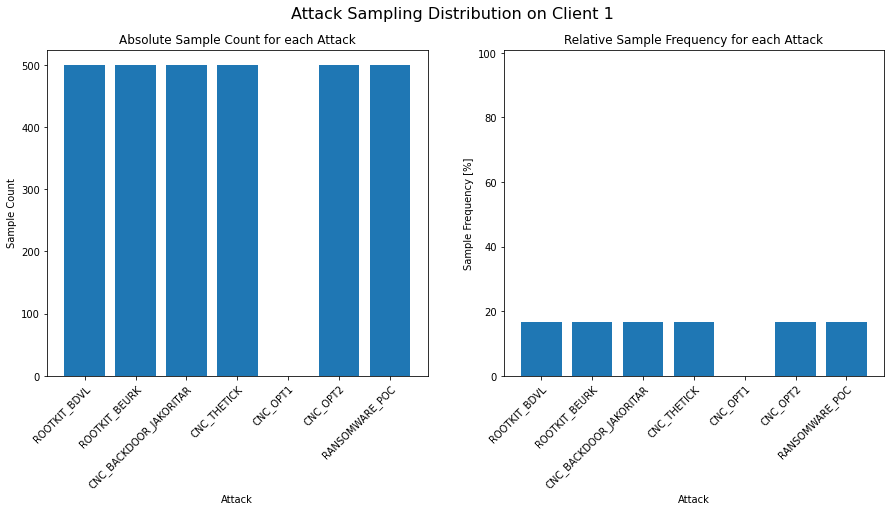

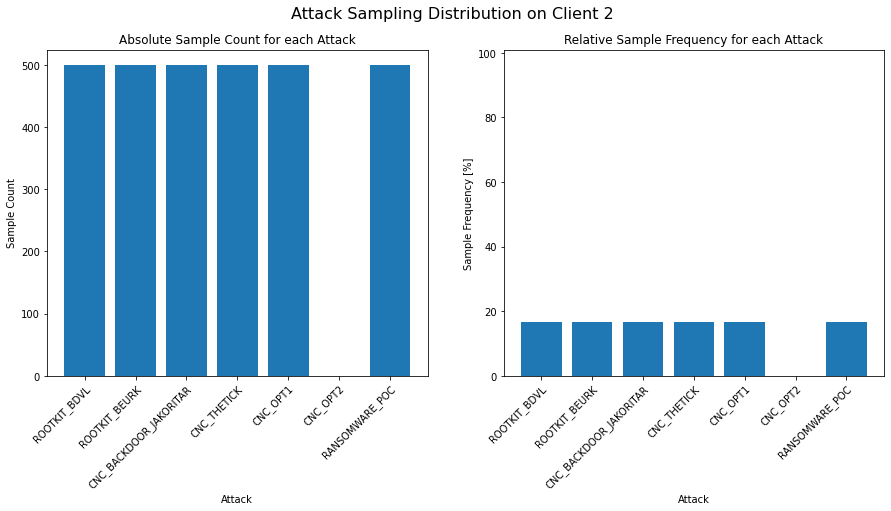

In [8]:
p2e3v1.plot_sampling_distributions()

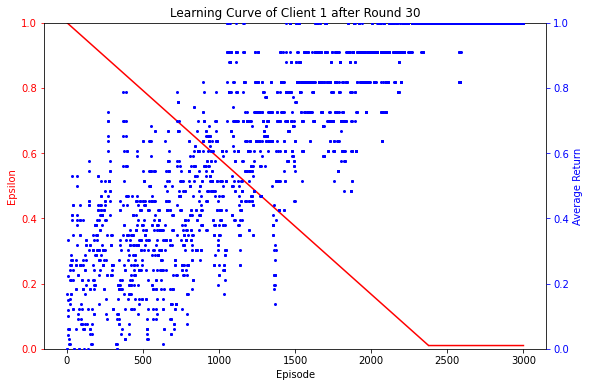

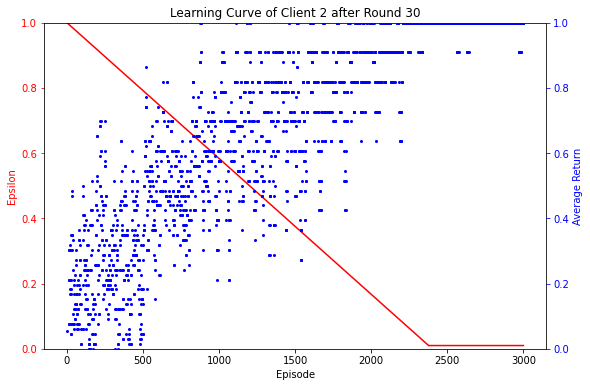

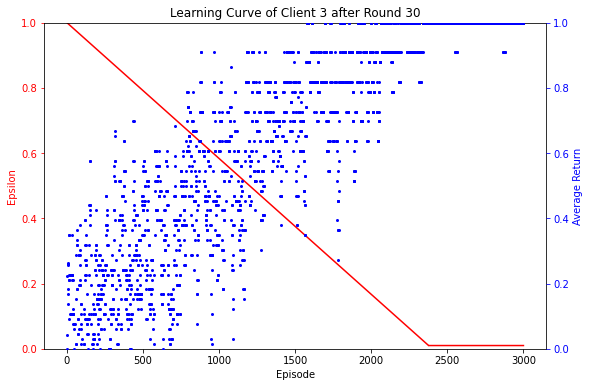

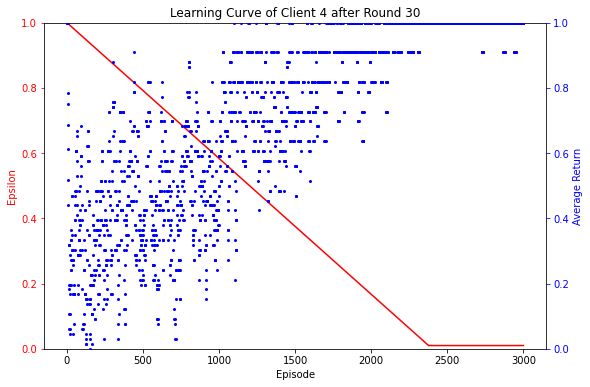

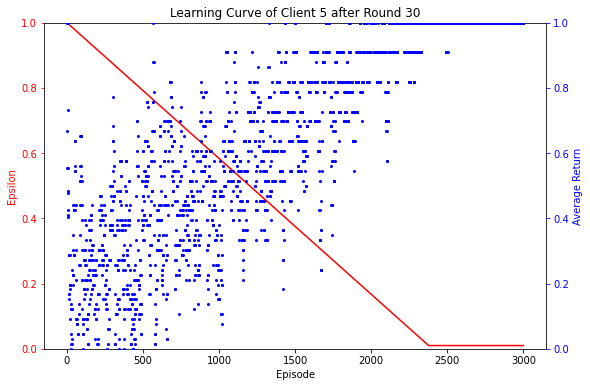

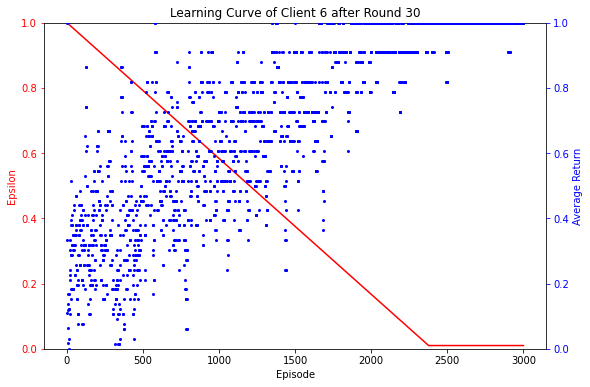

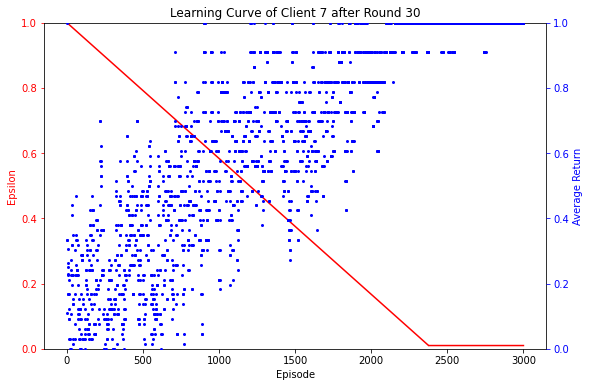

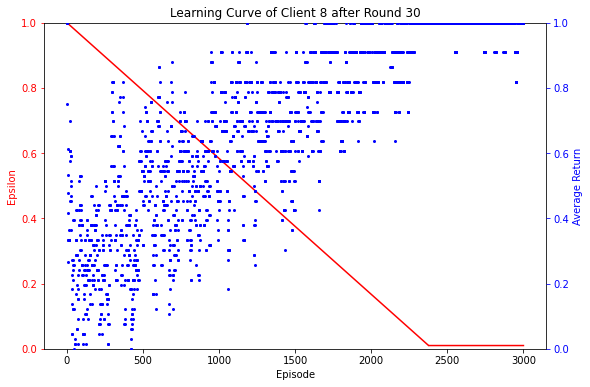

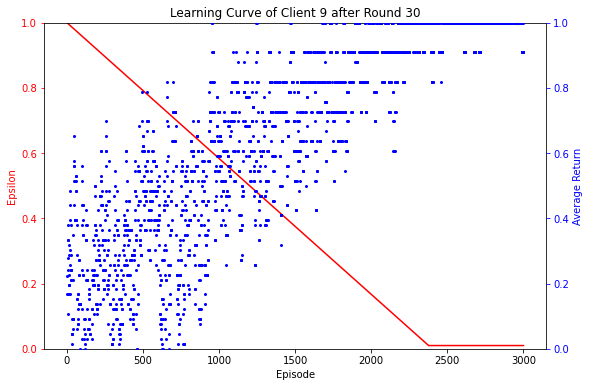

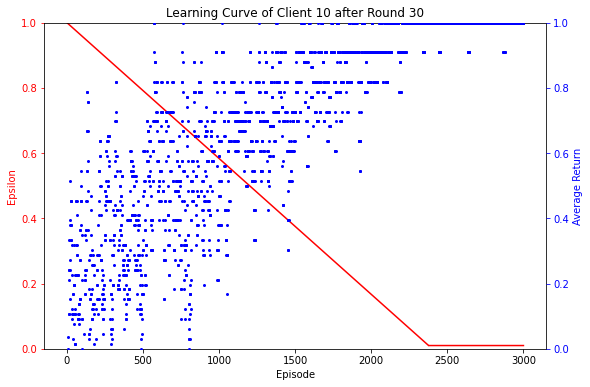

In [9]:
p2e3v1.show_learning_curves()

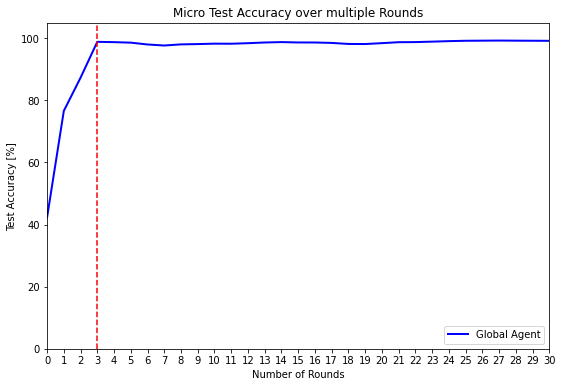

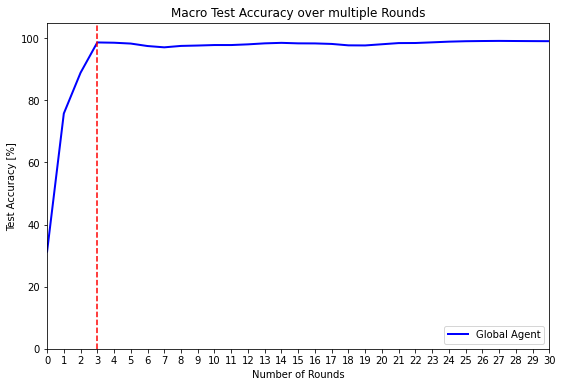

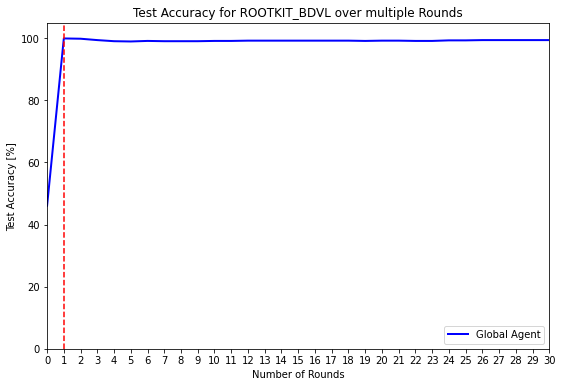

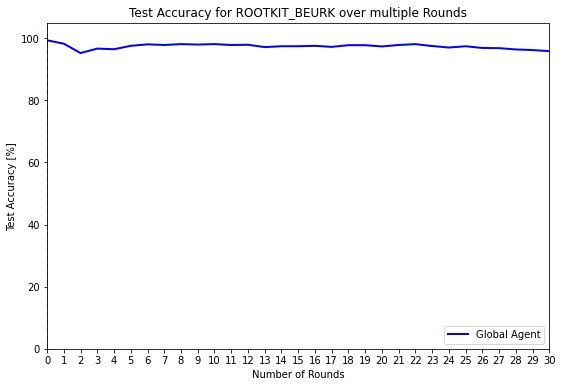

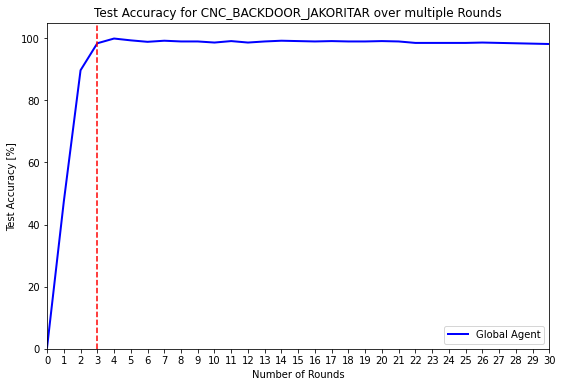

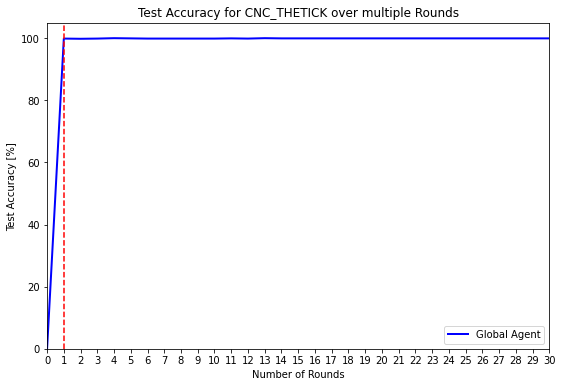

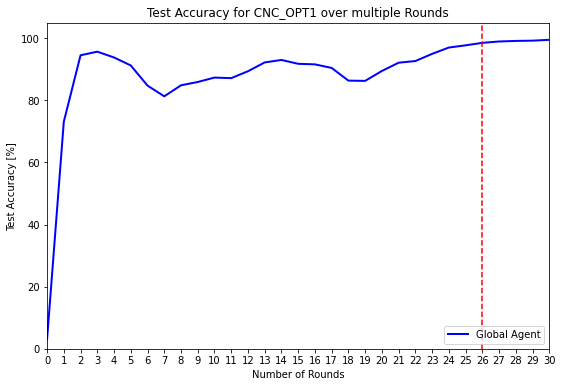

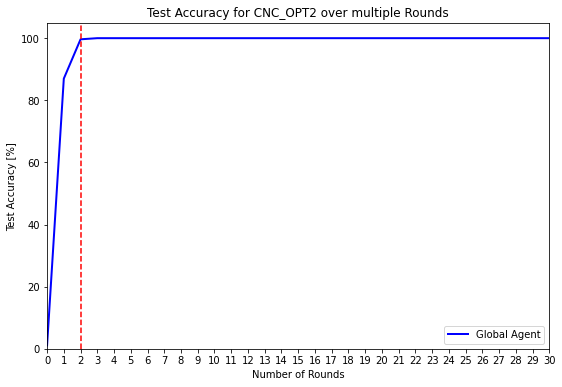

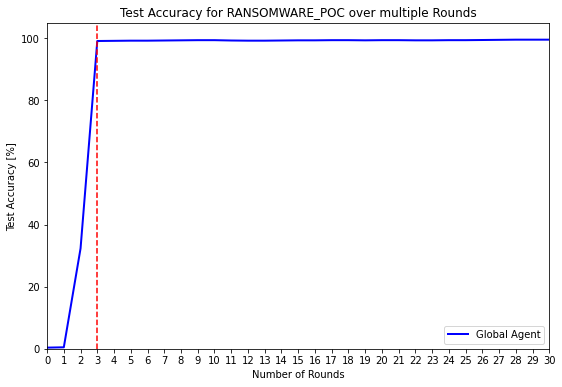

In [22]:
p2e3v1.show_experiment_graphs(y_threshold=98, show_individual_clients=False, y_log_scale=False)

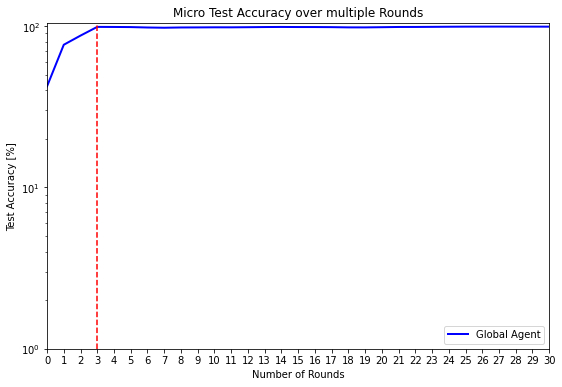

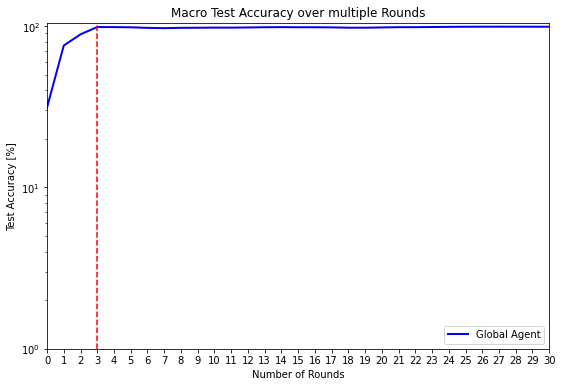

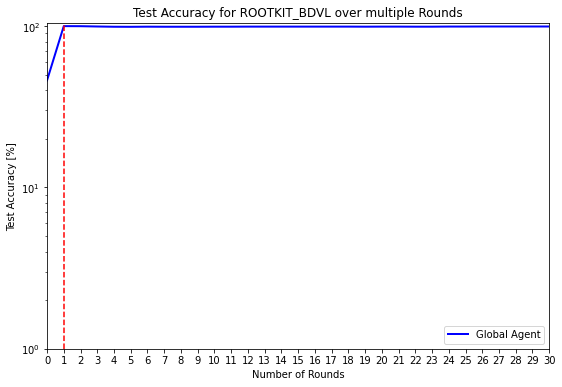

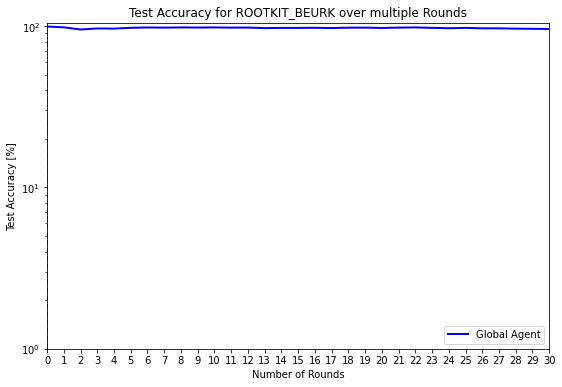

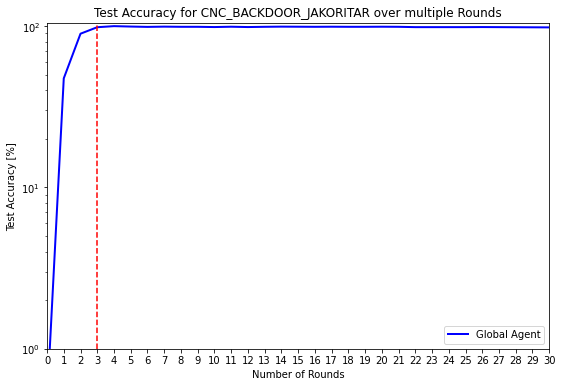

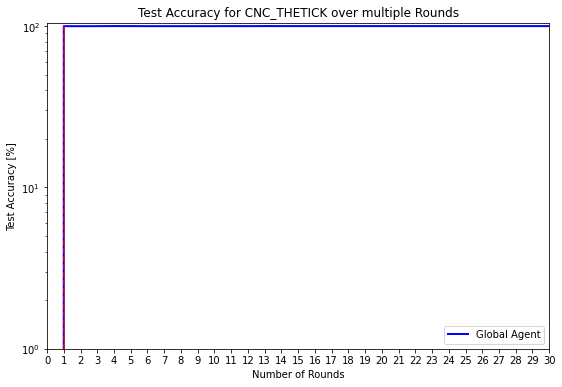

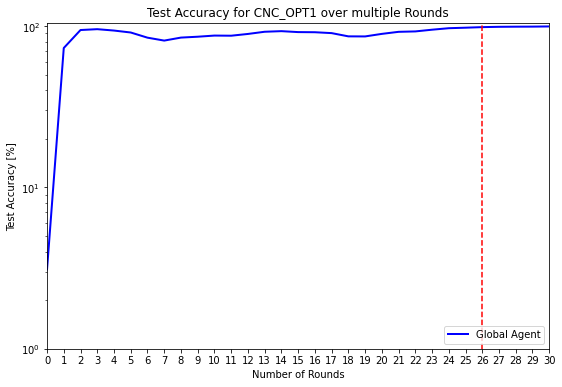

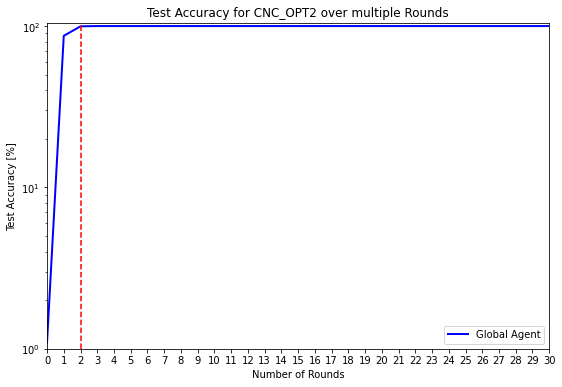

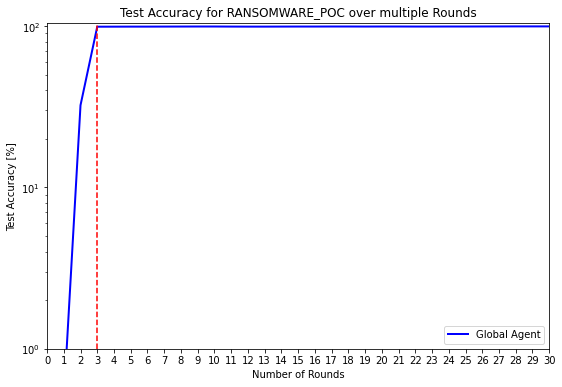

In [23]:
p2e3v1.show_experiment_graphs(y_threshold=98, show_individual_clients=False, y_log_scale=True)

---
## Experiment 2.3.2 (Medium Client Exclusive Class Setting)

In [12]:
p2e3v2 = run_sample_distribution_experiment(rl_training_data_strides, test_data, medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, autoencoder, 30, 100, False)



Dataset Balance Metrics: MID=0.0304 & WCS=0.8944
Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

Global Agent > Performance Evaluation after Round 0
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0.91 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      15.23 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      99.32 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |       0    | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |       0  

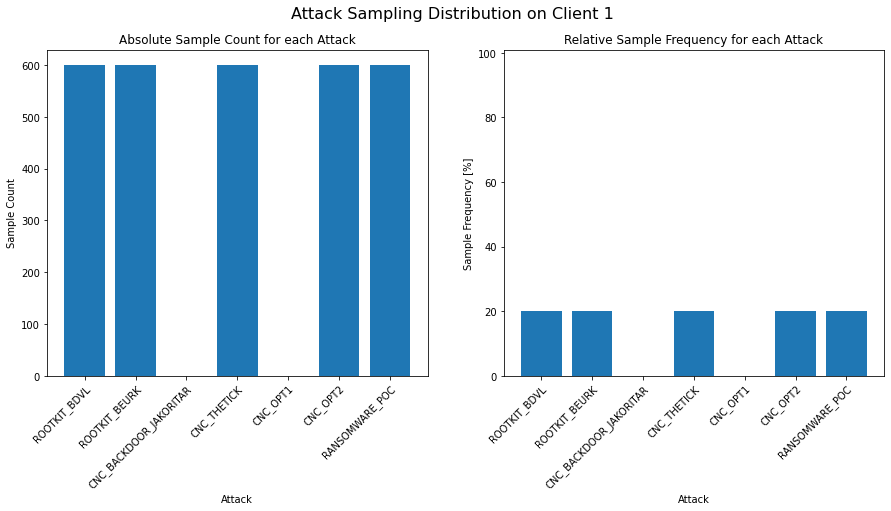

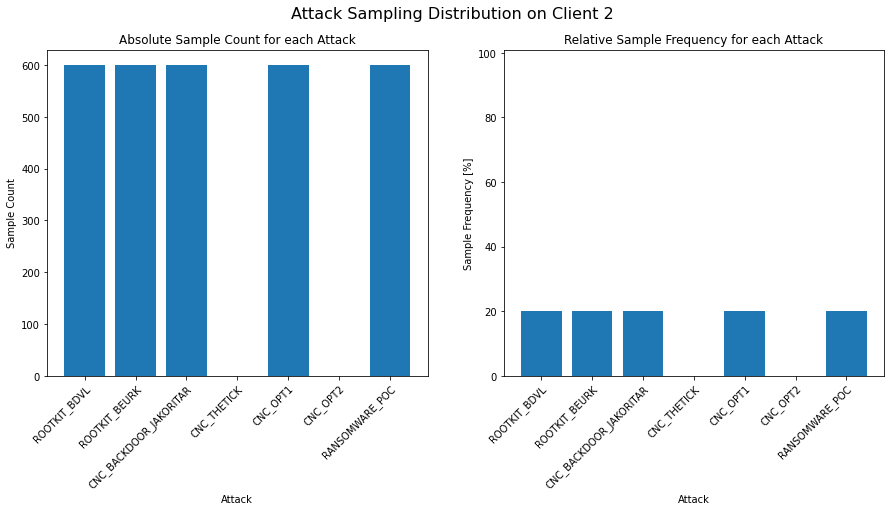

In [13]:
p2e3v2.plot_sampling_distributions()

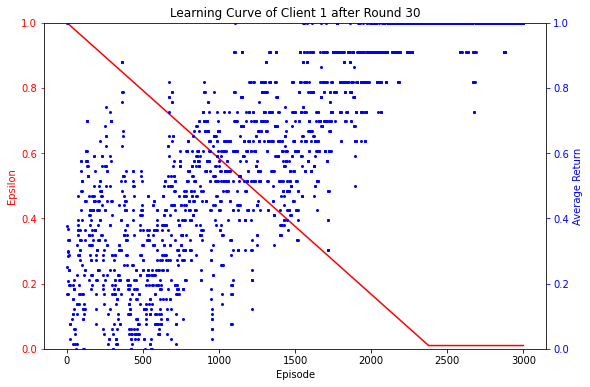

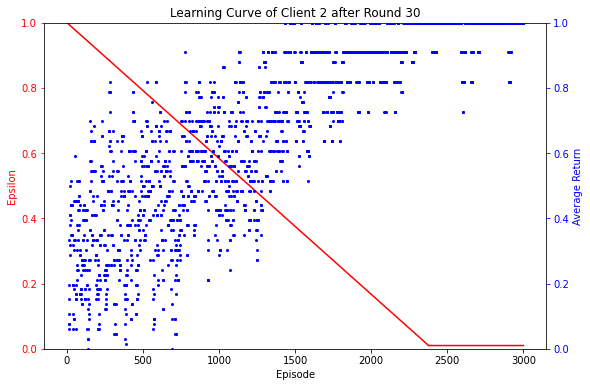

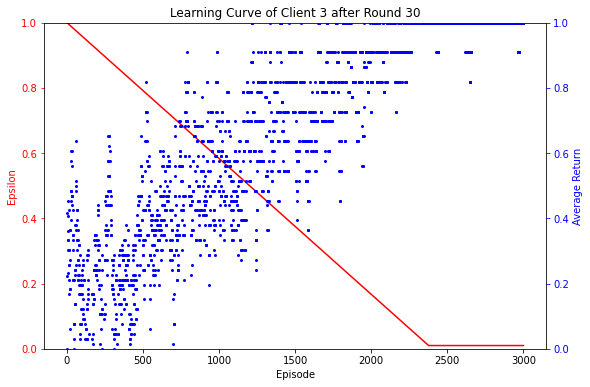

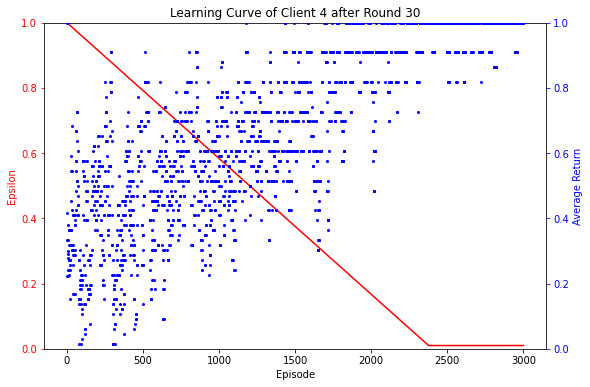

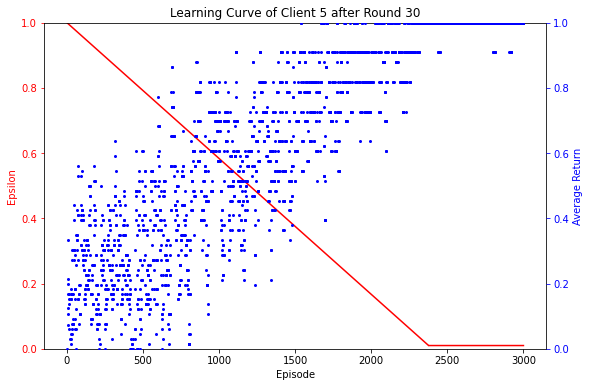

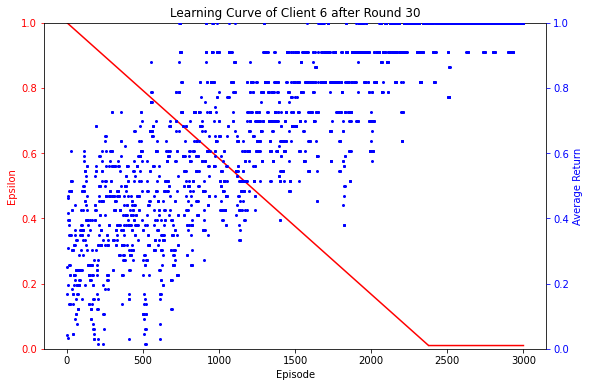

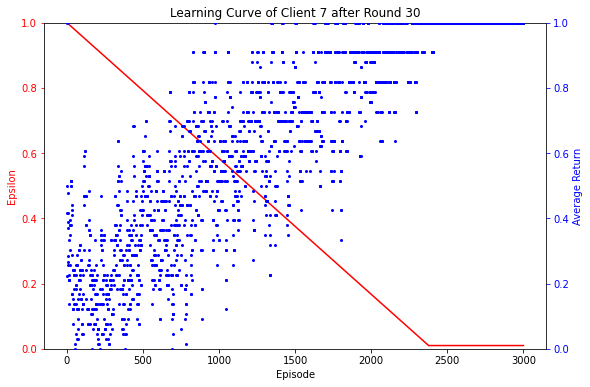

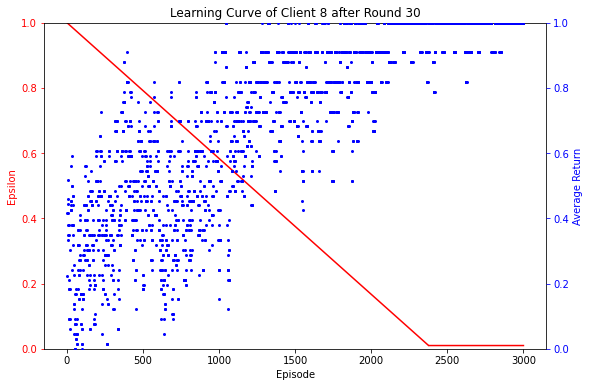

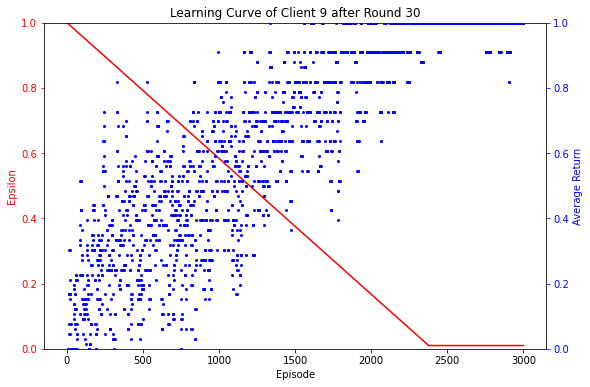

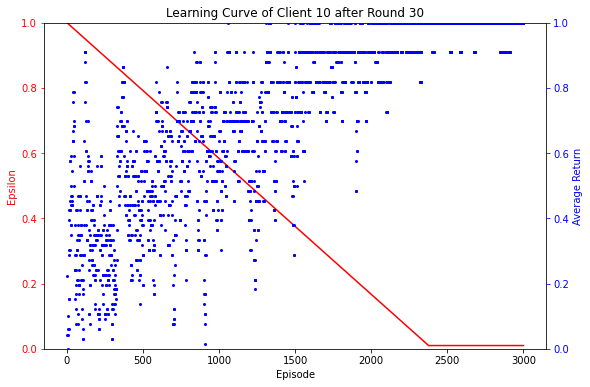

In [14]:
p2e3v2.show_learning_curves()

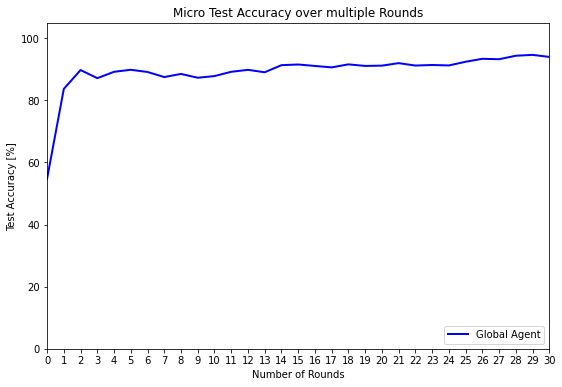

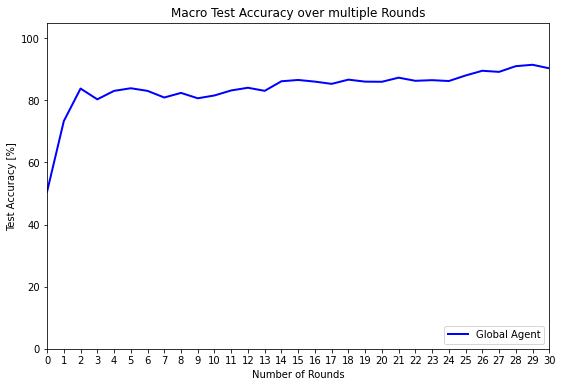

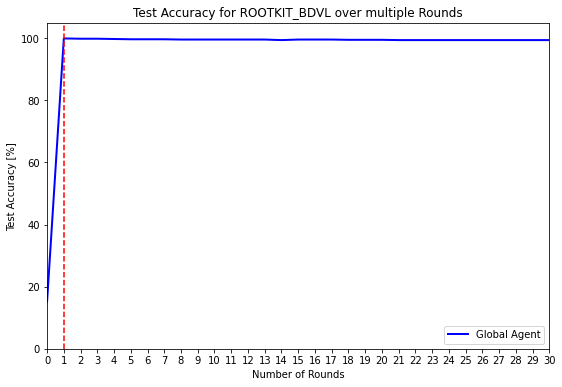

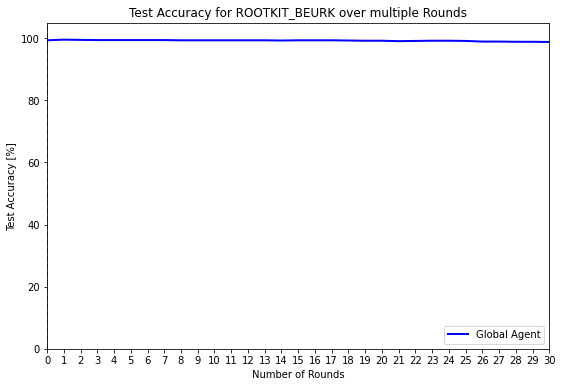

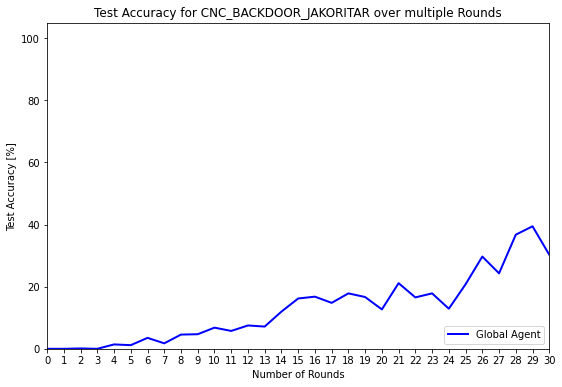

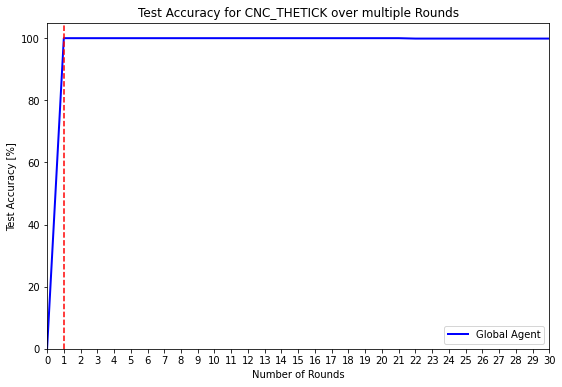

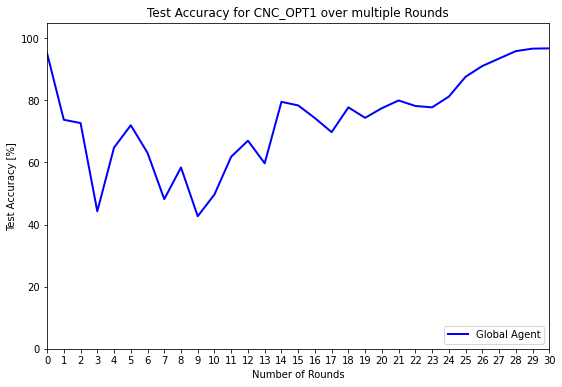

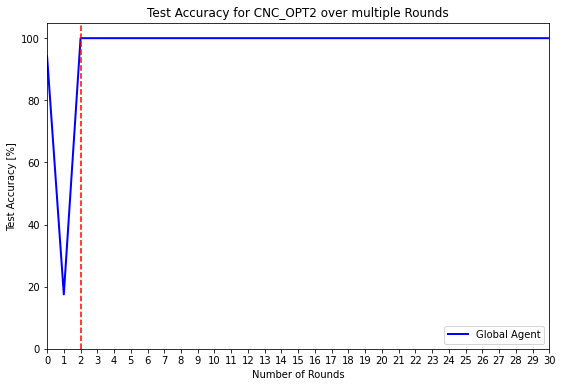

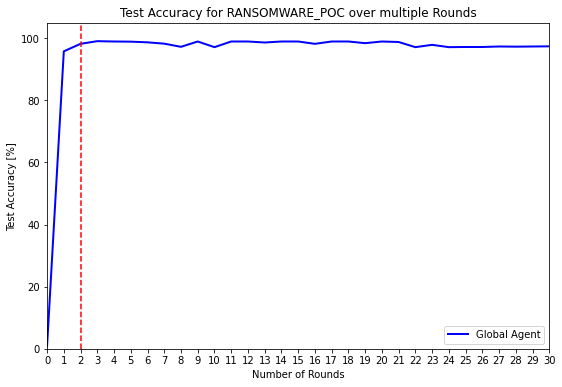

In [24]:
p2e3v2.show_experiment_graphs(y_threshold=98, show_individual_clients=False, y_log_scale=False)

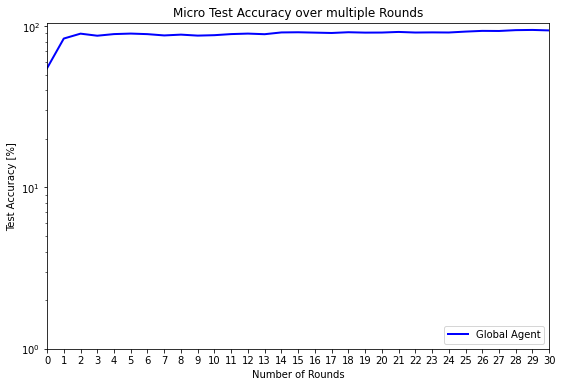

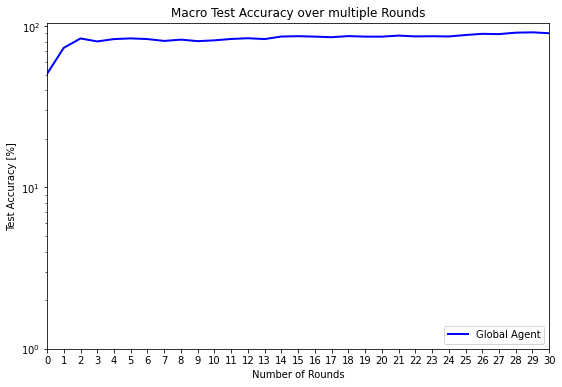

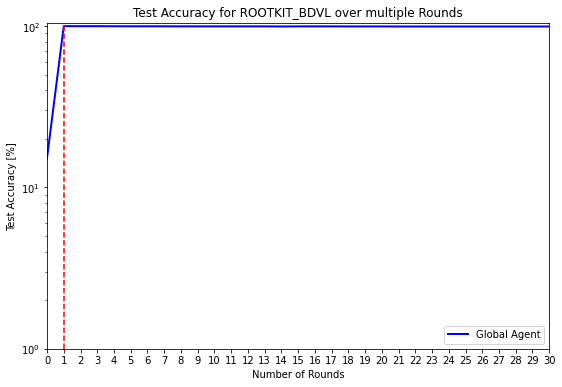

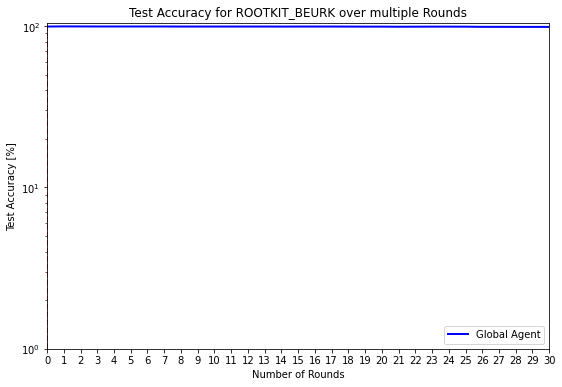

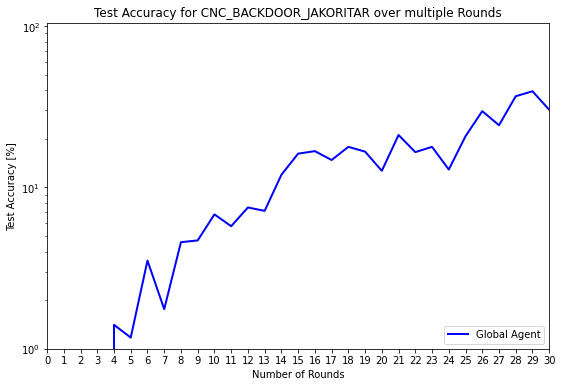

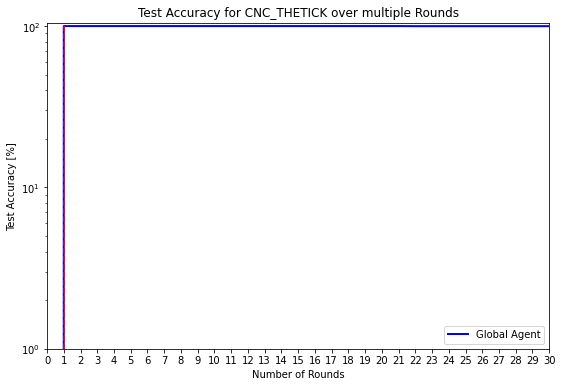

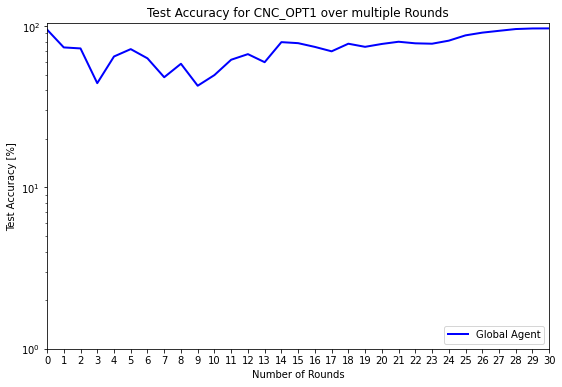

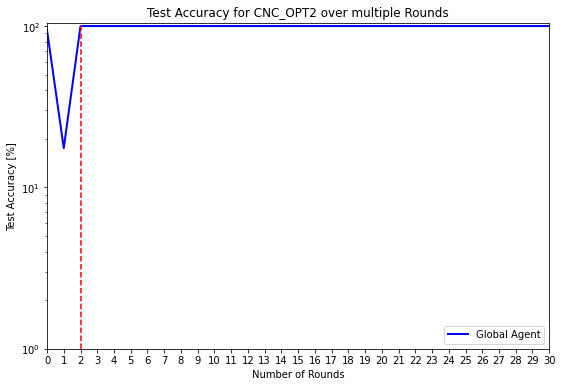

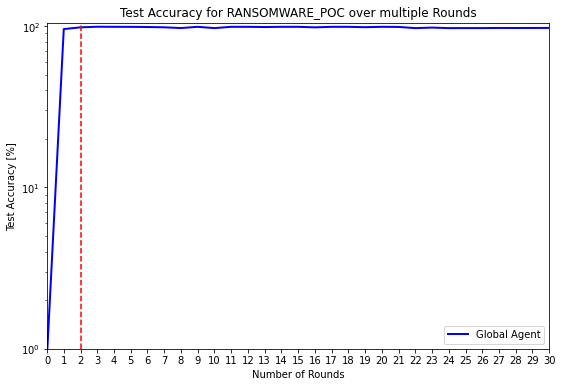

In [25]:
p2e3v2.show_experiment_graphs(y_threshold=98, show_individual_clients=False, y_log_scale=True)

---
## Experiment 2.3.3 (Strong Client Exclusive Class Setting)

In [17]:
p2e3v3 = run_sample_distribution_experiment(rl_training_data_strides, test_data, strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02, autoencoder, 30, 100, False)



Dataset Balance Metrics: MID=0.0053 & WCS=0.7053
Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

Global Agent > Performance Evaluation after Round 0
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0.21 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      58.99 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      97.26 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |      99.8  | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |       3.2

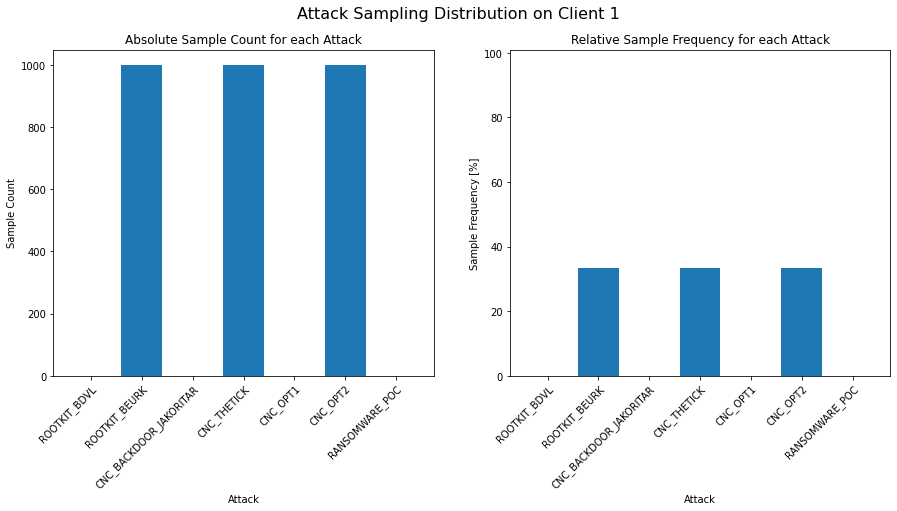

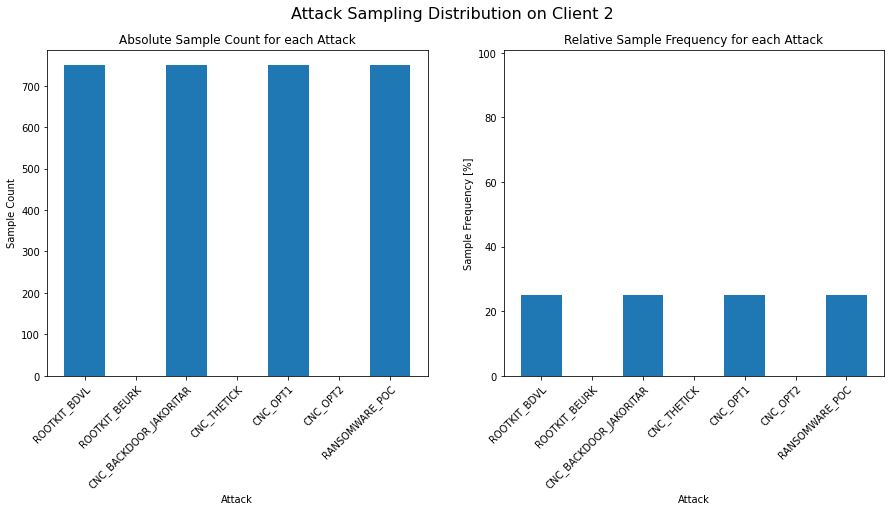

In [18]:
p2e3v3.plot_sampling_distributions()

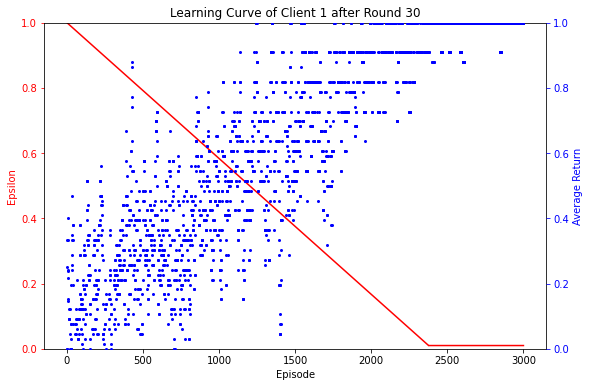

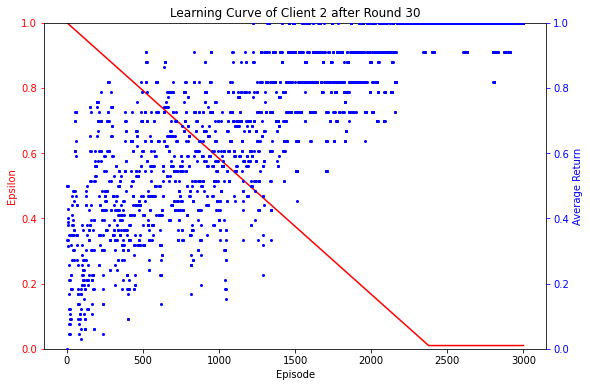

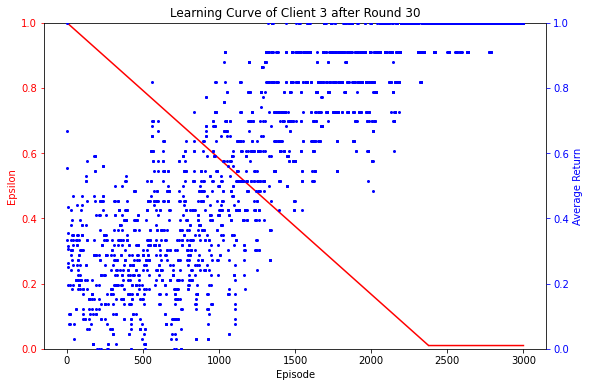

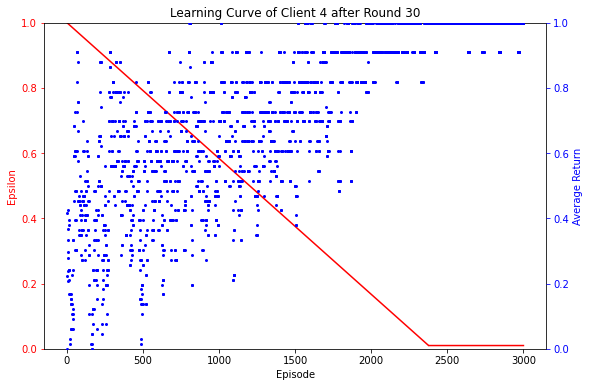

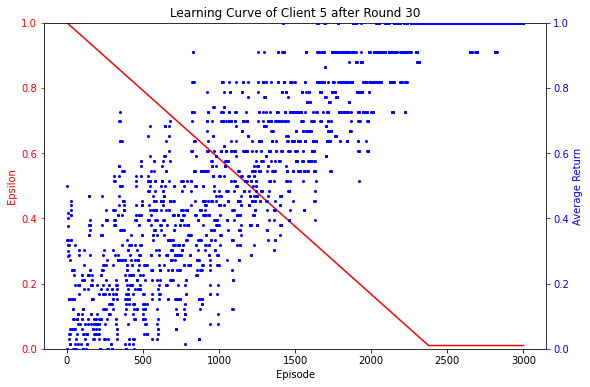

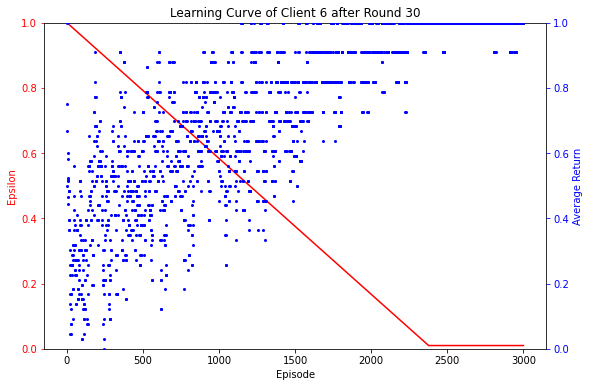

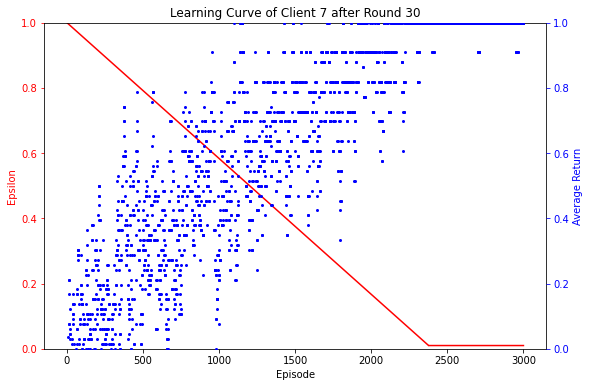

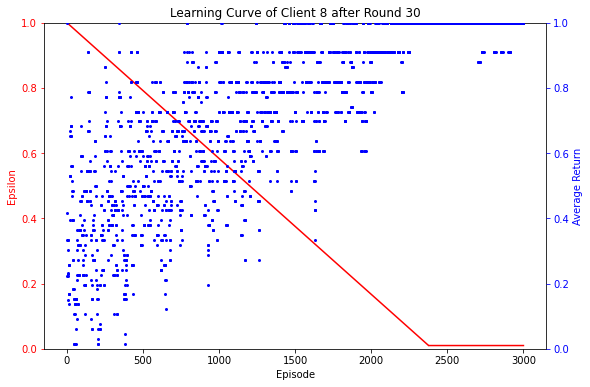

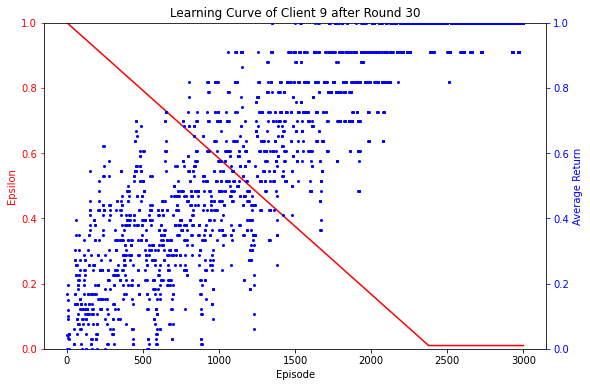

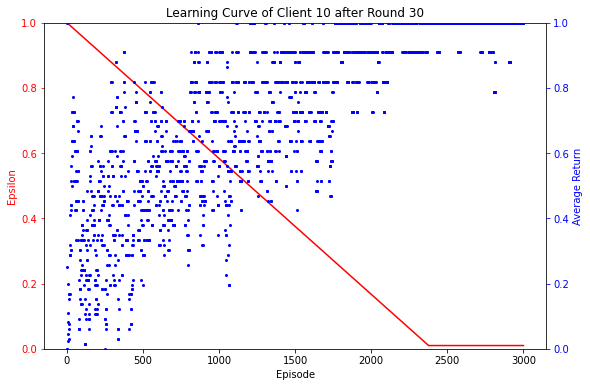

In [19]:
p2e3v3.show_learning_curves()

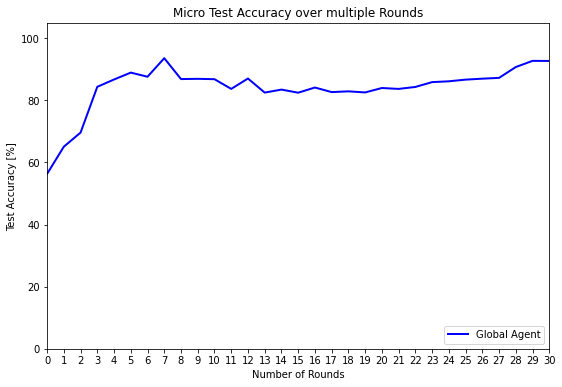

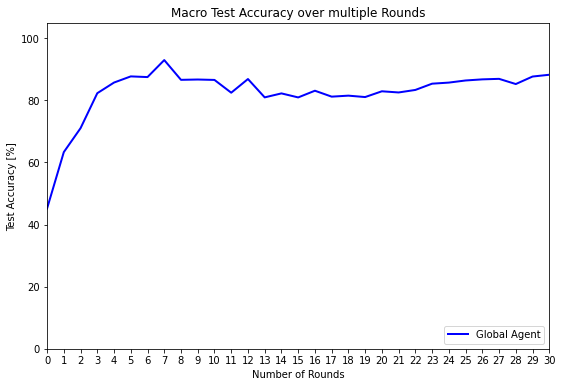

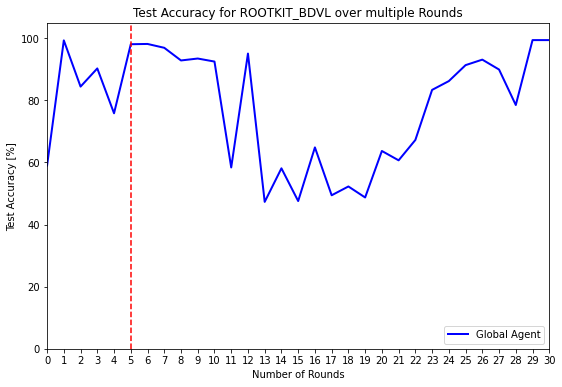

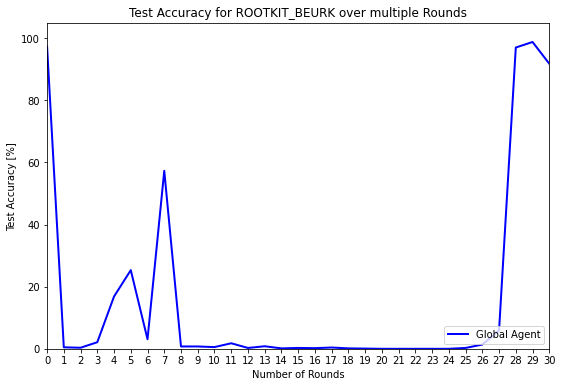

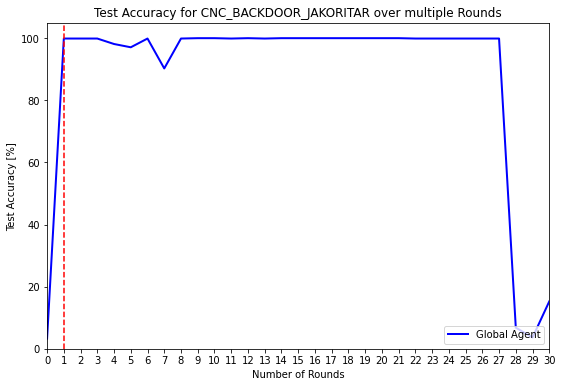

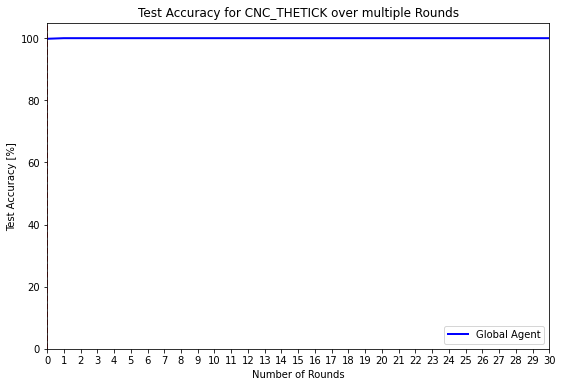

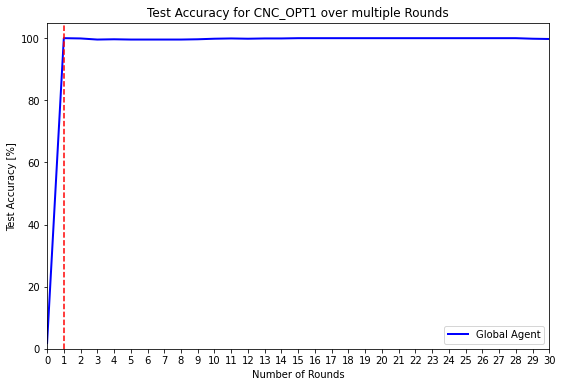

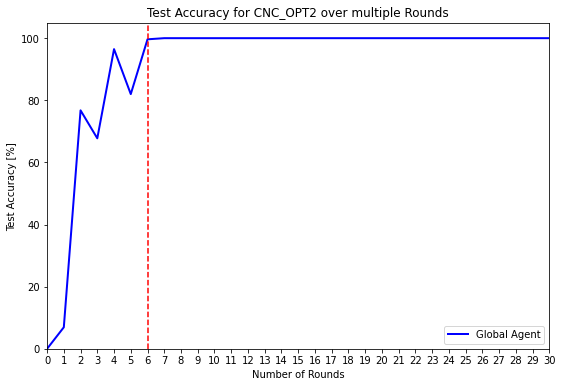

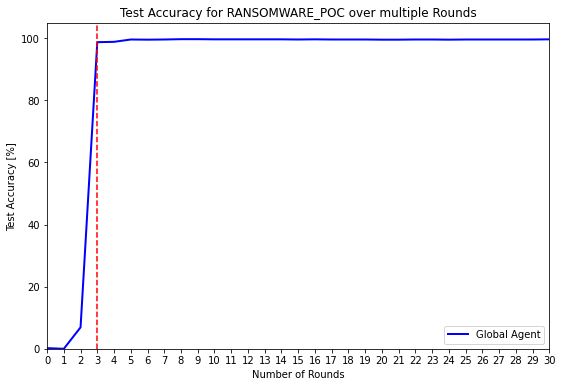

In [26]:
p2e3v3.show_experiment_graphs(y_threshold=98, show_individual_clients=False, y_log_scale=False)

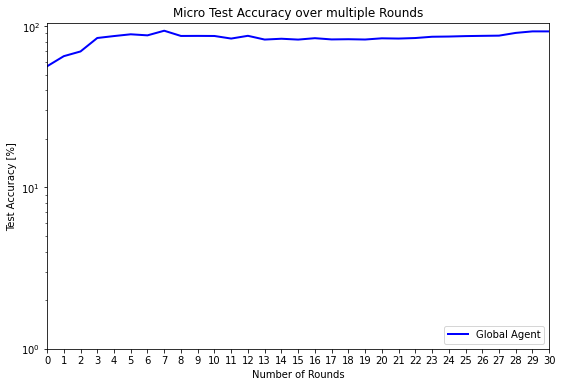

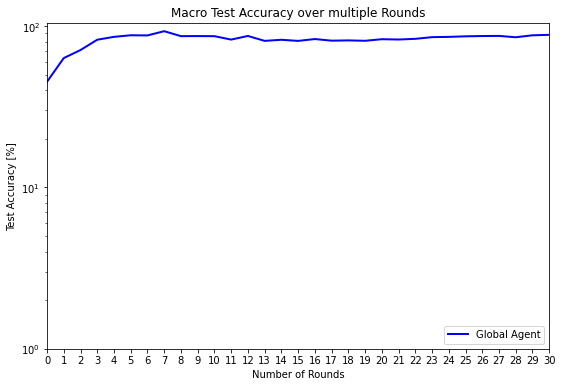

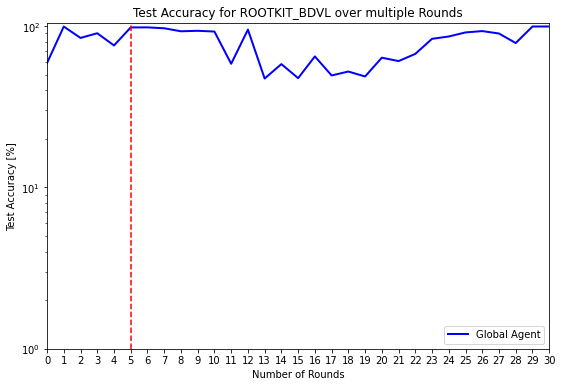

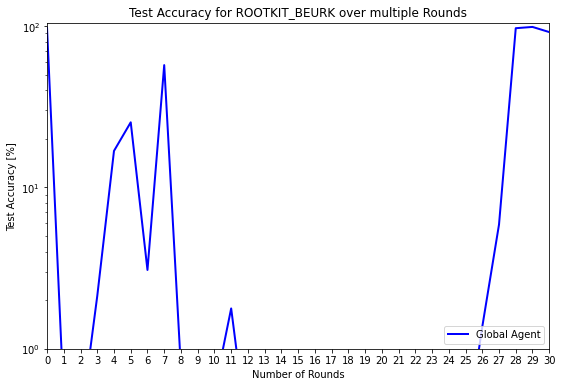

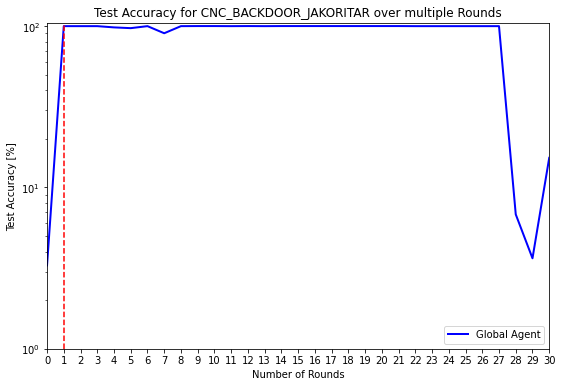

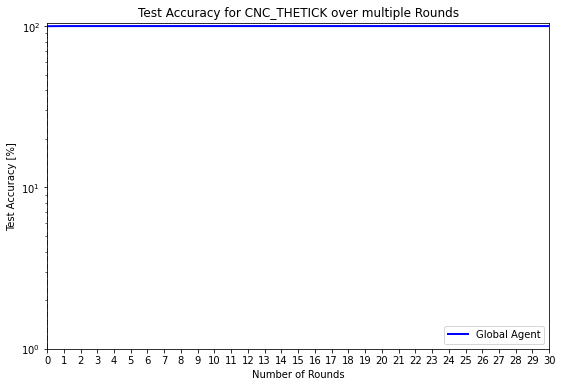

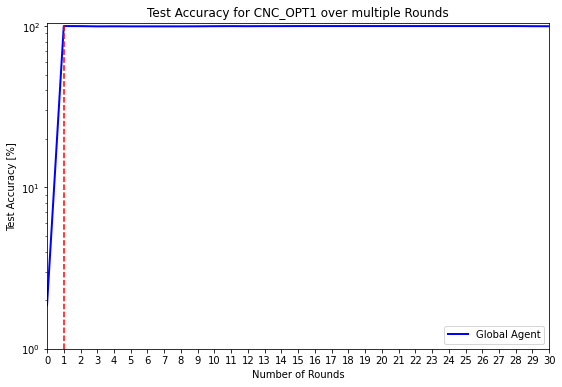

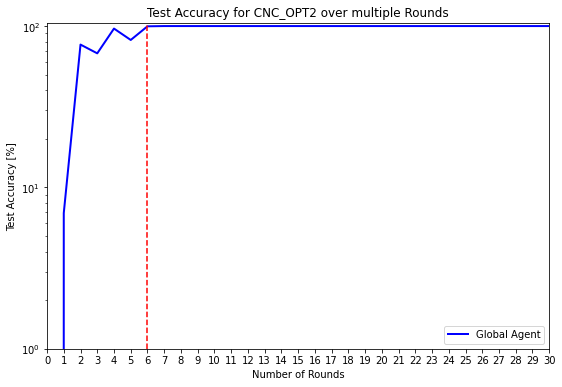

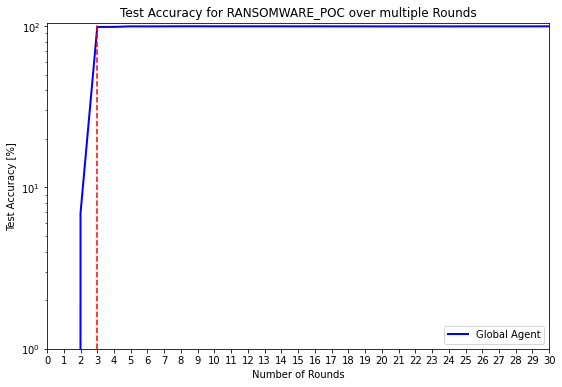

In [27]:
p2e3v3.show_experiment_graphs(y_threshold=98, show_individual_clients=False, y_log_scale=True)